In [1]:
print(__doc__)

import time
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation

from itertools import cycle, islice

Automatically created module for IPython interactive environment


In [2]:
datasets = [("organicVsOrganize",2,"pca_organicOrganizedFeatures_20170604123909916.csv",{0:"ORGANIC",1:"ORGANIZED"}),
            ("PoliticalVsNonPolitical",2,"pca_politicalNonPoliticalFeatures_20170604123909916.csv",{0:"NON-POLITICAL",1:"POLITICAL"}),
            ("ProTrumpVsProHillary",3,"pca_IrrelevantHillaryTrumpFeatures_20170604123909916.csv"
            ,{0:"HILLARY",1:"TRUMP",2:"IRRELEVANT"})
           ]

In [3]:
# ============
# Create cluster objects
# ============
def getClusteringFunctions(clusterNum,):
    randomStateVal = 0
    kmeans = KMeans(n_clusters=clusterNum,random_state=randomStateVal)
    two_means = cluster.MiniBatchKMeans(n_clusters=clusterNum,random_state=randomStateVal)
    spectral = cluster.SpectralClustering(n_clusters=clusterNum,random_state=randomStateVal)
    gmm = mixture.GaussianMixture(n_components=clusterNum,random_state=randomStateVal)
    average_linkage = cluster.AgglomerativeClustering(n_clusters=clusterNum)
    ward = cluster.AgglomerativeClustering(n_clusters=clusterNum)
    birch = cluster.Birch(n_clusters=clusterNum)
    ms = cluster.MeanShift(bin_seeding=True)
    dbscan = cluster.DBSCAN()
    affinity = AffinityPropagation()



    clustering_algorithms = (
            ('Gaussian Mixture', gmm),
            ('KMeans', kmeans),
            ('Ward', ward),
            ('Agglomerative Clustering', average_linkage),
            ('Spectral Clustering', spectral),
            ('Birch', birch),
            #('Affinity Propagation', affinity),
            ('Mean Shift', ms),
            ('DB Scan', dbscan) 
        )
    return clustering_algorithms

In [4]:
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        #[0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
        #[0.984375, 0.7265625, 0], # dark yellow
        [1, 1, 0.9]               # light yellow
    ])

In [5]:
def plotClusteringResults(dataSetTuple, xtickSet,xtickLiterals,borderaxespad,fileName):
    confusionMatrix = {}
    #plt.rcParams['figure.figsize'] = (8,8)
    plt.figure(figsize=(14, 11))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.35,
                    hspace=.35)
    sns.set_context("paper")
    
    dataSetName,clusterNum, datasetPath,labelDict = dataSetTuple
    plot_num = 1
    data = pd.read_csv(datasetPath)
    
    classIdValues = data['ClassId'].value_counts()
    for label in labelDict.keys():
        print(str(label) + ' - ' + labelDict[label] + ' - Count : ' + str(classIdValues[label])   )

    clustering_algorithms = getClusteringFunctions(clusterNum);
    algorithmCount = 0;
    for name, algorithm in clustering_algorithms :
        t0 = time.time()
        algorithmCount += 1
        trainingData = pd.read_csv(datasetPath)
        
                # catch warnings related to kneighbors_graph
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(trainingData.drop('ClassId',axis=1))

        
        newPredictionCol = name + "_prediction"
        if hasattr(algorithm, 'labels_'):
            data[newPredictionCol] = algorithm.labels_.astype(np.int)
        else:
            data[newPredictionCol] = algorithm.predict(trainingData.drop('ClassId',axis=1))

            
        predictionDistribution = data[newPredictionCol].value_counts()
        predictionCountCol = newPredictionCol + 'cnt'
        data[predictionCountCol] = data.apply(
            lambda row: ' Cluster size : ' 
            + str(predictionDistribution[row[newPredictionCol]]), axis=1)

        subplotIdx = 1
        #if((algorithmCount == 5)):
            #plt.show()
            #plt.figure(figsize=(14, 3))
            #plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.35,hspace=.35)
            #plot_num = 1
            #subplotIdx = 2
            
        plt.subplot(2, 4 ,plot_num)
        plt.title(name, size=10)

        #ax = sns.swarmplot(x="ClassId", y="index",
        #        hue=predictionCountCol,palette=get_colors(),
        #       data=data.reset_index())

        
        ax = sns.swarmplot(x="ClassId", y="index",
                 hue=predictionCountCol,
                 data=data.reset_index())
        #plt.legend(bbox_to_anchor=(1.05,1.05))
        #plt.legend(bbox_to_anchor=(1.30, 1.05), loc=1, borderaxespad=0.)
        plt.legend(loc=8,ncol=1,borderaxespad = borderaxespad )
        
        

        plt.xticks(xtickSet,xtickLiterals)
        plt.yticks(())
        plt.ylabel('')
        plt.xlabel('Data Labels')
        t1 = time.time()
        
        data = data.drop(predictionCountCol,axis=1)

        predictionArray = {}
        for classId in range(0,clusterNum):
            classDF = data[data['ClassId'] == classId]
            predictionArray[classId] = classDF[newPredictionCol].value_counts()
            
            
        confusionMatrix[name] = predictionArray
        

        plot_num += 1 

    plt.savefig(fileName+'.eps', format='eps', bbox_inches='tight')
    plt.show()
    return confusionMatrix

Organic vs. Organized
0 - ORGANIC - Count : 226
1 - ORGANIZED - Count : 625


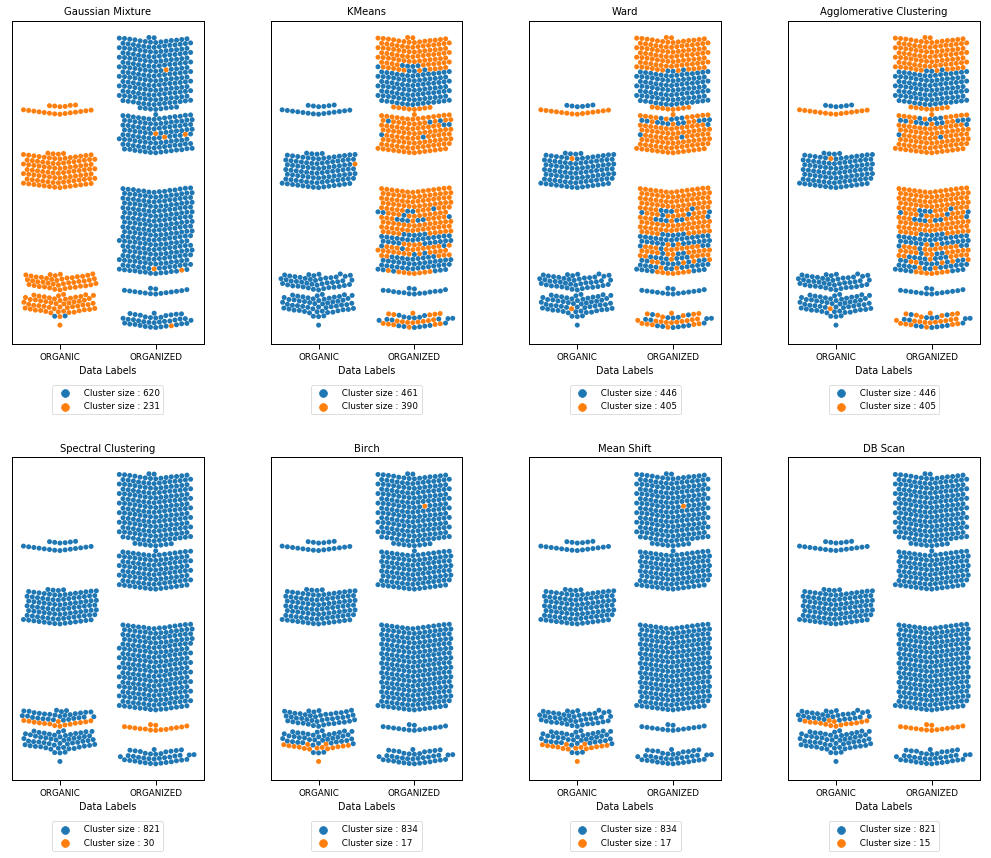

Political vs. Non-Political
0 - NON-POLITICAL - Count : 231
1 - POLITICAL - Count : 648


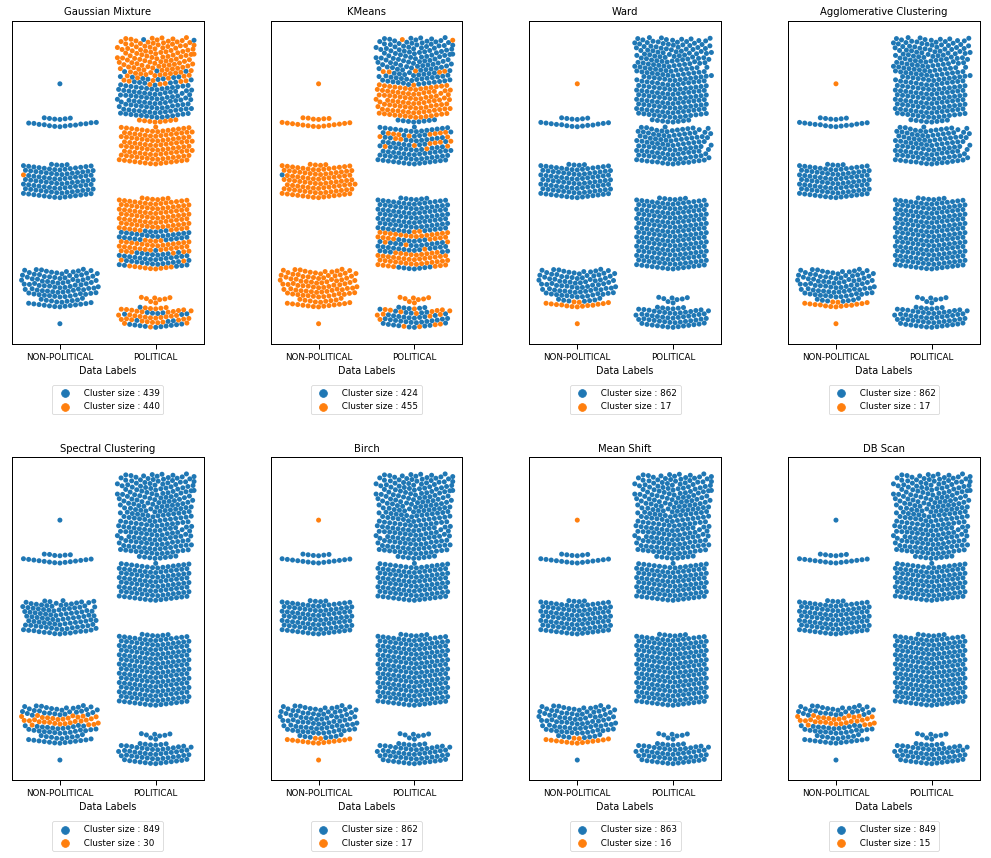

Pro-Trump vs. Pro-Hillary vs. Irrelevant
0 - HILLARY - Count : 170
1 - TRUMP - Count : 311
2 - IRRELEVANT - Count : 372


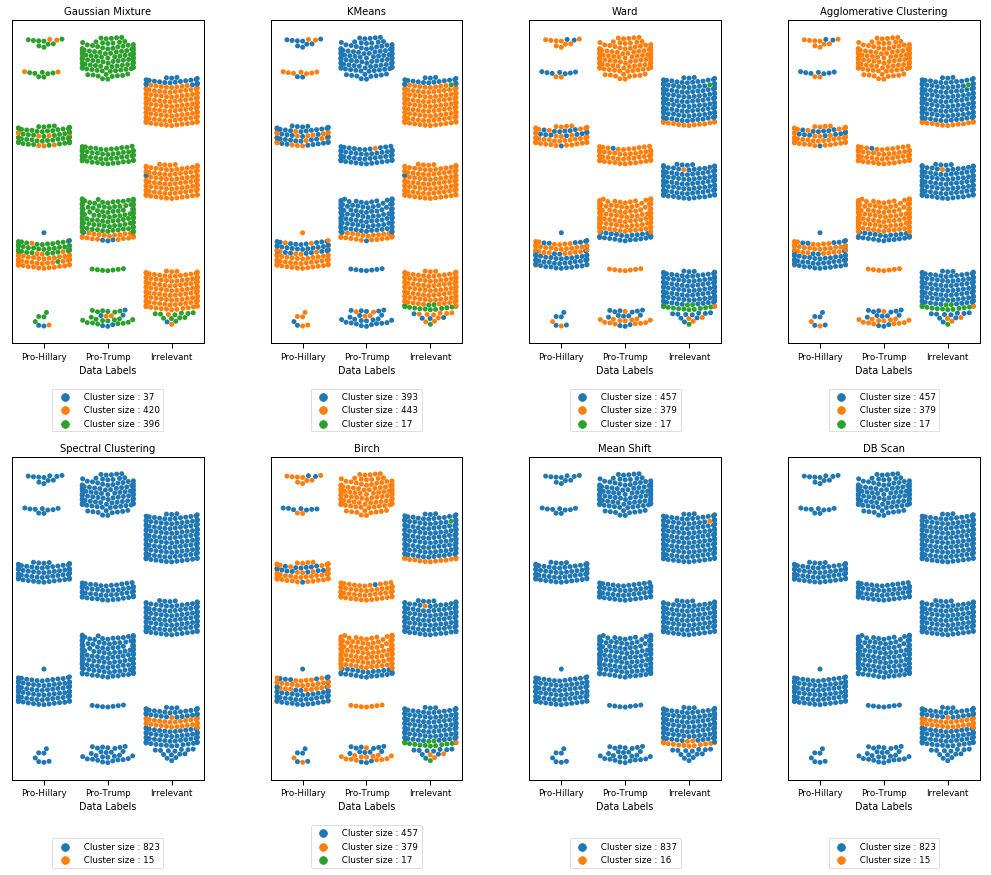

In [6]:
#confusionMatrix[]

print("Organic vs. Organized")
organizedConfMatrix = plotClusteringResults(datasets[0],(0,1),['ORGANIC','ORGANIZED'],-8,'unspervisedForOrganic')

print("Political vs. Non-Political")
politicalConfMatrix = plotClusteringResults(datasets[1],(0,1),['NON-POLITICAL','POLITICAL'],-8,'unspervisedForPolitic')

print("Pro-Trump vs. Pro-Hillary vs. Irrelevant")
proTrumpConfMatrix = plotClusteringResults(datasets[2],(0,1,2),['Pro-Hillary','Pro-Trump','Irrelevant'],-10,'unspervisedForProTrumps')

In [7]:
def printConfMatrix(confMatrix,clusterNum):
    for algortihm in confMatrix:
        print("\n\n------------")
        print(algortihm)
        print("------------")
        for classId in confMatrix[algortihm]:
            print('Predictions for ClassId : ' + str(classId))
            predictionDistribution = confMatrix[algortihm][classId]
            #print("Prediction Distribution : ")
            
            for i in range(0,clusterNum):
                if i in predictionDistribution:
                    print(str(i) + " - " + str(predictionDistribution[i]))     
         

In [8]:
print("Organic vs Organized")
printConfMatrix(organizedConfMatrix,2)

Organic vs Organized


------------
Gaussian Mixture
------------
Predictions for ClassId : 0
0 - 2
1 - 224
Predictions for ClassId : 1
0 - 618
1 - 7


------------
KMeans
------------
Predictions for ClassId : 0
0 - 1
1 - 225
Predictions for ClassId : 1
0 - 389
1 - 236


------------
Ward
------------
Predictions for ClassId : 0
0 - 210
1 - 16
Predictions for ClassId : 1
0 - 236
1 - 389


------------
Agglomerative Clustering
------------
Predictions for ClassId : 0
0 - 210
1 - 16
Predictions for ClassId : 1
0 - 236
1 - 389


------------
Spectral Clustering
------------
Predictions for ClassId : 0
0 - 211
1 - 15
Predictions for ClassId : 1
0 - 610
1 - 15


------------
Birch
------------
Predictions for ClassId : 0
0 - 210
1 - 16
Predictions for ClassId : 1
0 - 624
1 - 1


------------
Mean Shift
------------
Predictions for ClassId : 0
0 - 210
1 - 16
Predictions for ClassId : 1
0 - 624
1 - 1


------------
DB Scan
------------
Predictions for ClassId : 0
1 - 15
Predictions for Class

In [9]:
print("Non-Political vs Political")
printConfMatrix(politicalConfMatrix,2)

Non-Political vs Political


------------
Gaussian Mixture
------------
Predictions for ClassId : 0
0 - 230
1 - 1
Predictions for ClassId : 1
0 - 209
1 - 439


------------
KMeans
------------
Predictions for ClassId : 0
0 - 1
1 - 230
Predictions for ClassId : 1
0 - 423
1 - 225


------------
Ward
------------
Predictions for ClassId : 0
0 - 214
1 - 17
Predictions for ClassId : 1
0 - 648


------------
Agglomerative Clustering
------------
Predictions for ClassId : 0
0 - 214
1 - 17
Predictions for ClassId : 1
0 - 648


------------
Spectral Clustering
------------
Predictions for ClassId : 0
0 - 201
1 - 30
Predictions for ClassId : 1
0 - 648


------------
Birch
------------
Predictions for ClassId : 0
0 - 214
1 - 17
Predictions for ClassId : 1
0 - 648


------------
Mean Shift
------------
Predictions for ClassId : 0
0 - 215
1 - 16
Predictions for ClassId : 1
0 - 648


------------
DB Scan
------------
Predictions for ClassId : 0
0 - 15
1 - 15
Predictions for ClassId : 1


In [10]:
print("Pro-Trump vs Pro-Hillary")
printConfMatrix(proTrumpConfMatrix,3)

Pro-Trump vs Pro-Hillary


------------
Gaussian Mixture
------------
Predictions for ClassId : 0
0 - 60
1 - 106
2 - 4
Predictions for ClassId : 1
0 - 22
1 - 279
2 - 10
Predictions for ClassId : 2
0 - 338
1 - 11
2 - 23


------------
KMeans
------------
Predictions for ClassId : 0
0 - 85
2 - 85
Predictions for ClassId : 1
0 - 27
2 - 284
Predictions for ClassId : 2
0 - 331
1 - 17
2 - 24


------------
Ward
------------
Predictions for ClassId : 0
0 - 82
1 - 88
Predictions for ClassId : 1
0 - 39
1 - 272
Predictions for ClassId : 2
0 - 336
1 - 19
2 - 17


------------
Agglomerative Clustering
------------
Predictions for ClassId : 0
0 - 82
1 - 88
Predictions for ClassId : 1
0 - 39
1 - 272
Predictions for ClassId : 2
0 - 336
1 - 19
2 - 17


------------
Spectral Clustering
------------
Predictions for ClassId : 0
0 - 170
Predictions for ClassId : 1
0 - 311
Predictions for ClassId : 2
0 - 342
1 - 15
2 - 15


------------
Birch
------------
Predictions for ClassId : 0
0 - 82
2 - 88
Predictio